# 1. Marchenko-Pastur distribution

In this section we will generate $n$ random vectors of dimension $p$ according to the spiked covariance model:
$$x_i = a_iv+ \sigma\xi_i$$
### (I) MP's Distribution as applied on the Spiked Model
We will start with making some helper functions, a modified version to the example from the class.

In [1]:
# helper fuctions for the simulation
import numpy as np
import matplotlib.pyplot as plt
def marchpast(l, g,sigma):
    """Marchenko-Pastur distribution
    input: - g determines the shape of the distribution (MP) - sqrt(p/n)
           -sigma - the scale of the normal distribution
           -l - points in axis to compute the MP distribution
    return: the MP distribution for points in l"""
    def m0(a):
        "Element wise maximum of (a,0)"
        return np.maximum(a, np.zeros_like(a))
    
    gplus=(sigma*(1+g**0.5))**2
    gminus=(sigma*(1-g**0.5))**2
    return np.sqrt(  m0(gplus  - l) *  m0(l- gminus)) / ( 2*np.pi*g*l*(sigma**2))

def generate_alpa_v_vectors(n,p):
    """Generate random scalars alpha_i from the standard normal distribution"""
    v = np.random.randn(n)
    v /= np.linalg.norm(v)
    a = np.random.randn(p)
    return a,v

def cv(a):
    "Covariance matrix"
    return (np.matmul(a, a.transpose())/a.shape[1])

def randcv(n, p, sigma,a,v):
    """
    Input:
    n,p dimension of random matrix
    sigma - scale of normal distribution
    s - number of random matrices to generate
    Returns: a covariance matrix
    """
    # # Generate standard random multivariate Gaussian vectors xi
    xi = np.random.randn(n, p)
    x = (a[:, np.newaxis] * v).T + sigma * xi
    x = x-np.mean(x)
    r = cv(x)
    return r

def EE(a, gamma,sigma,to_plot=True):
    "Calculate and show histogram of eigenvalues"
    ee, ev =np.linalg.eigh(a)
    if to_plot:
      nn, bb, patches=plt.hist(ee.ravel(),bins="auto",density=True)
      x=np.arange(bb[0], bb[-1], 0.003)
      y = marchpast(x, gamma,sigma)
      return x,y,nn,ee,ev
    return ee, ev


Use the following parameters: $n = 300$; $p = 50$;$\sigma = 1$. Generate a plot with a histogram of the eigenvalues of the
covariance matrix $$R = \frac{1}{n}\sum_i{x_i x_i^T}$$. Also a line plot of Marchenko Pastur distribution is added followed by a short explanation.

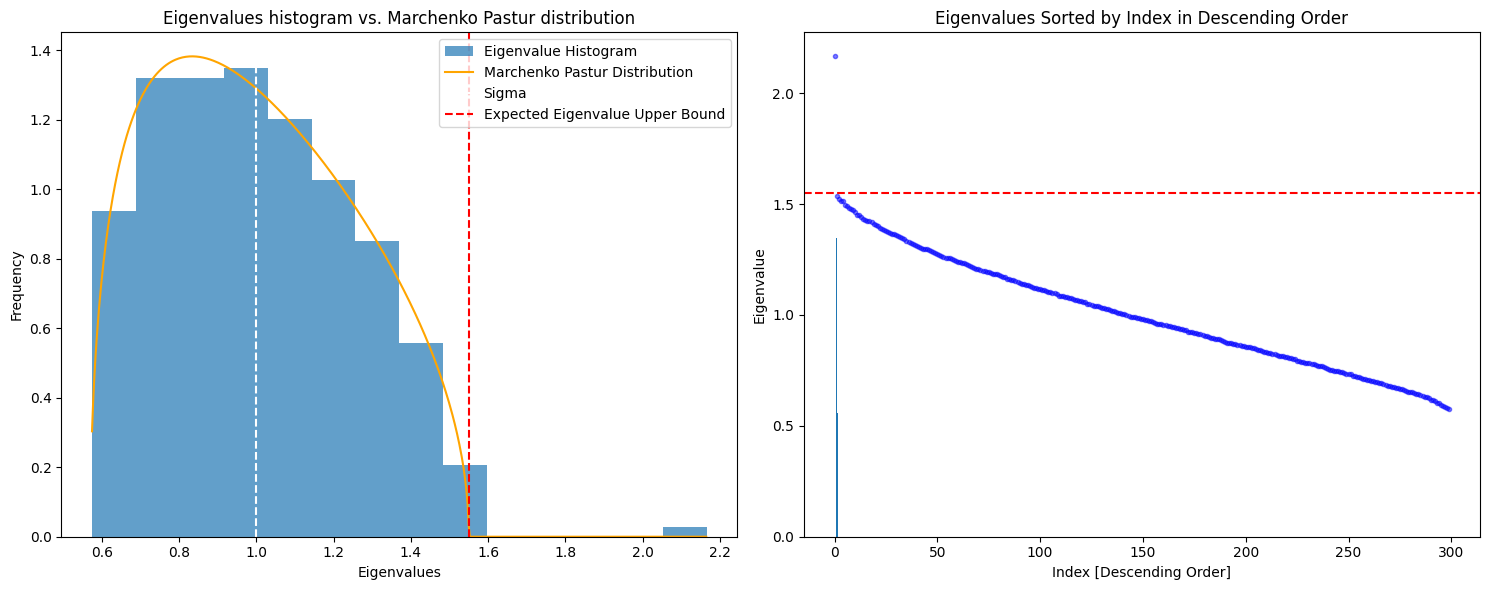

Max Eigenvalue:  2.165854587575402
Upper MP Boundary: 1.5498979485566355


In [9]:
# Set the parameters and 
p = 300
n = 5000
sigma = 1
a,v = generate_alpa_v_vectors(p,n)
r = randcv(p,n,sigma,a,v)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
x, y, nn, ee,ev = EE(r, p/n, sigma)
upper_boundary = (sigma * (1 + (p/n)**0.5))**2

axs[0].hist(ee.ravel(), bins="auto", density=True, alpha=0.7, label='Eigenvalue Histogram')
axs[0].plot(x, y, color='orange',  label='Marchenko Pastur Distribution')
axs[0].axvline(x=sigma, color='white', linestyle='--', label='Sigma')
axs[0].axvline(x=upper_boundary, color='red', linestyle='--', label='Expected Eigenvalue Upper Bound')
axs[0].set_title("Eigenvalues histogram vs. Marchenko Pastur distribution")
axs[0].set_xlabel('Eigenvalues')
axs[0].set_ylabel('Frequency')
axs[0].legend(loc='upper right')
# Scatter plot of eigenvalues against their indices on axs[1]
axs[1].scatter(np.arange(0, len(ee)), np.sort(ee)[::-1], marker='.', color='blue', alpha=0.5)
axs[1].axhline(y=upper_boundary, color='red', linestyle='--', label='Expected Eigenvalue Upper Bound')
axs[1].set_title('Eigenvalues Sorted by Index in Descending Order')
axs[1].set_xlabel('Index [Descending Order]')
axs[1].set_ylabel('Eigenvalue')

plt.tight_layout()
plt.show()
print("Max Eigenvalue: ",np.max(ee))
print("Upper MP Boundary:",upper_boundary)

Indeed the eigenvalues larger than the upper bound of the Marchenko-Pastur distribution is considered a signal (meaningful component), while the rest that lay within the bounds are considered noise.
This plot offer a visual method to distinguish between the 'signal' and 'noise' in the data, which is especially useful for dimensionality reduction and for understanding the intrinsic complexity of the dataset.

### (II) MP's Distribution and the Spiked Model 
#### with $\sigma \isin \{0.2,0.4,..,1.8,2\} $
In this section we first compute the leading eigenvector of the covariance matrix $R$ and compute the absolute value of its inner product with $v$.

In [13]:
sigma_lst = np.arange(0, 2.1, 0.2)
v_lv_ip_lst = []
for s in sigma_lst:
  a,v = generate_alpa_v_vectors(p,n)
  r = randcv(p,n,s,a,v)
  ee,ev = EE(r, p/n, s,to_plot = False)
  max_variance_index = np.argmax(ee)

  # Get the corresponding eigenvector
  leading_eigenvector = ev[:, max_variance_index]
  v_lv_ip = np.abs(np.dot(leading_eigenvector, v))
  v_lv_ip_lst.append(v_lv_ip)

Then we plot the results as a function of $\sigma$.

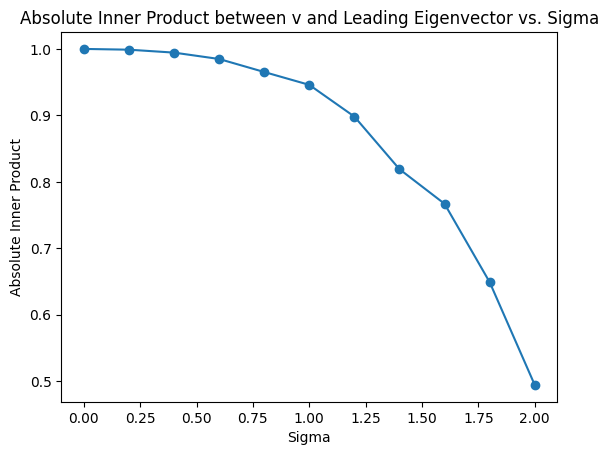

In [14]:
plt.plot(sigma_lst, v_lv_ip_lst, marker='o')
plt.title("Absolute Inner Product between v and Leading Eigenvector vs. Sigma")
plt.xlabel("Sigma")
plt.ylabel("Absolute Inner Product")
plt.show()

#### What makes the result start to degrade?
Recall that in the Spiked Covariance model, $v$ represents the eigenvector corresponding to the largest eigenvalue.

When the extracted eigenvector is the same as the real eigenvector, their inner product will return 1.
The more the subspace of our extracted eigenvector differs from the space of $v$,  their inner product of the noised eigenvector with vector will approach 0. As we know, when vectors represent different spaces they are orthogonal.
Hence, **the greatest the noise ($\sigma$) is, the bigger the harder it is to extract our objective signal.**  

# 2. Kernel Functions and Mercer's Theorem

### Given that:
> $f_{1}\left(x_{i},x_{j}\right)=\left\langle \phi_{1}\left(x_{i}\right),\phi_{1}\left(x_{j}\right)\right\rangle$ 
> $f_{2}\left(x_{i},x_{j}\right)=\left\langle \phi_{2}\left(x_{i}\right),\phi_{2}\left(x_{j}\right)\right\rangle$

are valid Kernel functions.

### We will show that:
> $f_{1}\left(x_{i},x_{j}\right)\cdot f_{2}\left(x_{i},x_{j}\right)$ 

is a valid Kernel as well.

$f_{1}\left(x_{i},x_{j}\right)\cdot f_{2}\left(x_{i},x_{j}\right)$
$=\left\langle \phi_{1}\left(x_{i}\right),\phi_{1}\left(x_{j}\right)\right\rangle \cdot\overset{scalar}{\overbrace{\left\langle \phi_{2}\left(x_{i}\right),\phi_{2}\left(x_{j}\right)\right\rangle }}=\left\langle \phi_{1}\left(x_{i}\right),\phi_{1}\left(x_{j}\right)\left\langle \phi_{2}\left(x_{i}\right),\phi_{2}\left(x_{j}\right)\right\rangle \right\rangle =\sum_{l}\left\langle \phi_{2}\left(x_{i}\right),\phi_{2}\left(x_{j}\right)\right\rangle \phi_{1}\left(x_{i}\right)_{l}\phi_{1}\left(x_{j}\right)_{l}$
 $=\sum_{l}\left[\sum_{k}\phi_{2}\left(x_{i}\right)_{k}\phi_{2}\left(x_{j}\right)_{k}\right]\phi_{1}\left(x_{i}\right)_{l}\phi_{1}\left(x_{j}\right)_{l}=\sum_{l}\sum_{k}\phi_{1}\left(x_{i}\right)_{l}\phi_{2}\left(x_{i}\right)_{k}\phi_{2}\left(x_{j}\right)_{k}\phi_{1}\left(x_{j}\right)_{l}=\sum_{l}\left\langle \phi_{1}\left(x_{i}\right)_{l}\phi_{2}\left(x_{i}\right),\phi_{2}\left(x_{j}\right)\phi_{1}\left(x_{j}\right)_{l}\right\rangle$

Hence, 
$f_{1}\left(x_{i},x_{j}\right)\cdot f_{2}\left(x_{i},x_{j}\right)=\sum_{l}\left\langle \phi_{1}\left(x_{i}\right)_{l}\phi_{2}\left(x_{i}\right),\phi_{2}\left(x_{j}\right)\phi_{1}\left(x_{j}\right)_{l}\right\rangle $

is a sum of inner products :
$\left\langle \phi_{1}\left(x_{i}\right)_{l}\phi_{2}\left(x_{i}\right),\phi_{2}\left(x_{j}\right)\phi_{1}\left(x_{j}\right)_{l}\right\rangle $, where each $\phi_{2}$
is multiplied by scalar $\phi_{1l}$.

Each $\left\langle \phi_{1}\left(x_{i}\right)_{l}\phi_{2}\left(x_{i}\right),\phi_{2}\left(x_{j}\right)\phi_{1}\left(x_{j}\right)_{l}\right\rangle $ is a valid kernel, since a valid Kernel multiplied by a scalar is a valid Kernel.
 
Hence, by the property $f_{3}\left(x_{i},x_{j}\right)=f_{1}\left(x_{i},x_{j}\right)+f_{2}\left(x_{i},x_{j}\right)$ the sum of valid kernels is a valid Kernel as well.

———–

Lets define 
$f_{1}\left(x_{i},x_{j}\right)=\left(1+x_{i}^{T}x_{j}\right),f_{2}\left(x_{i},x_{j}\right)=\left(1+x_{i}^{T}x_{j}\right)^{2}$, both valid Kernel functions, as we learned in class.

Therefore, $f_{3}\left(x_{i},x_{j}\right)=f_{1}\left(x_{i},x_{j}\right)\cdot f_{2}\left(x_{i},x_{j}\right)=\left(1+x_{i}^{T}x_{j}\right)^{3}$ is a valid Kernel as well.
 
Therefore, any function in the form $\left(1+x_{i}^{T}x_{j}\right)^{d}$  represents a multiplication of 
$\left(1+x_{i}^{T}x_{j}\right)$ and $\left(1+x_{i}^{T}x_{j}\right)^{2}$ **thus constituting a valid kernel, as demonstrated by the established property**.

We can denote: $d=\sum_{i}1+\sum_{j}2$
<br>and achieve:<br>
$f_{d}=\left(1+x_{i}^{T}x_{j}\right)^{d}=\left(1+x_{i}^{T}x_{j}\right)^{\sum_{i}1+\sum_{j}2}=\left(1+x_{i}^{T}x_{j}\right)^{\sum_{i}1}\cdot\left(1+x_{i}^{T}x_{j}\right)^{\sum_{j}2}$

$ =\left(1+x_{i}^{T}x_{j}\right)\cdot\left(1+x_{i}^{T}x_{j}\right)\cdots\left(1+x_{i}^{T}x_{j}\right)\cdot\left(1+x_{i}^{T}x_{j}\right)^{2}\cdot\left(1+x_{i}^{T}x_{j}\right)^{2}\cdots\left(1+x_{i}^{T}x_{j}\right)^{2}$
 
It's evident that  $f_{d}$  is a multiplication of valid kernels, thereby confirming its validity as a kernel.



**We can establish this through induction as well:**

For $d=1,2$ we have:
$f_{1}\left(x_{i},x_{j}\right)=\left(1+x_{i}^{T}x_{j}\right),f_{1}\left(x_{i},x_{j}\right)=\left(1+x_{i}^{T}x_{j}\right)^{2}$, 

both of which are valid kernel functions.

We have previously proven this for $d=3$
Assuming it holds for $d=n-1$:
$f_{n-1}\left(x_{i},x_{j}\right)=\left(1+x_{i}^{T}x_{j}\right)^{n-1}$ is a valid Kernel

Now, to prove for $d=n$ or $d=n+1$
From the induction assumption, $f_{n-1}$ is a valid kernel, and it's given that $f_{1}$ is also a valid kernel.
Multiplying two valid kernels yields a valid kernel:
$f_{n}\left(x_{i},x_{j}\right)=f_{n-1}\cdot f_{1}=\left(1+x_{i}^{T}x_{j}\right)^{n-1}\cdot\left(1+x_{i}^{T}x_{j}\right)=\left(1+x_{i}^{T}x_{j}\right)^{n}=\left(1+x_{i}^{T}x_{j}\right)^{d}$ is a valid Kernel, 
as multiplication of two valid Kernels are a valid Kernel
We can extend this proof to $d=n+1$ since it involves multiplying $f_{n-1}$ with $f_{2}$, which are both valid kernel functions.

Therefore, the same reasoning applies, confirming the validity of the kernel for $d=n+1.$

# 3 Kernel PCA to Non-Linearly Distributed Data

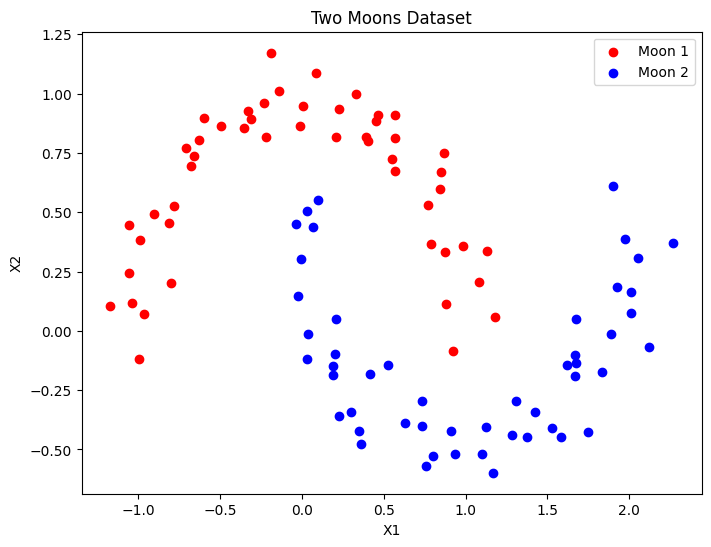

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate the two moons dataset
X_moons, y_moons = make_moons(n_samples=100, noise=0.1, random_state=42)

# Plotting the two moons dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_moons[y_moons == 0][:, 0], X_moons[y_moons == 0][:, 1], color='red', label='Moon 1')
plt.scatter(X_moons[y_moons == 1][:, 0], X_moons[y_moons == 1][:, 1], color='blue', label='Moon 2')
plt.title("Two Moons Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()


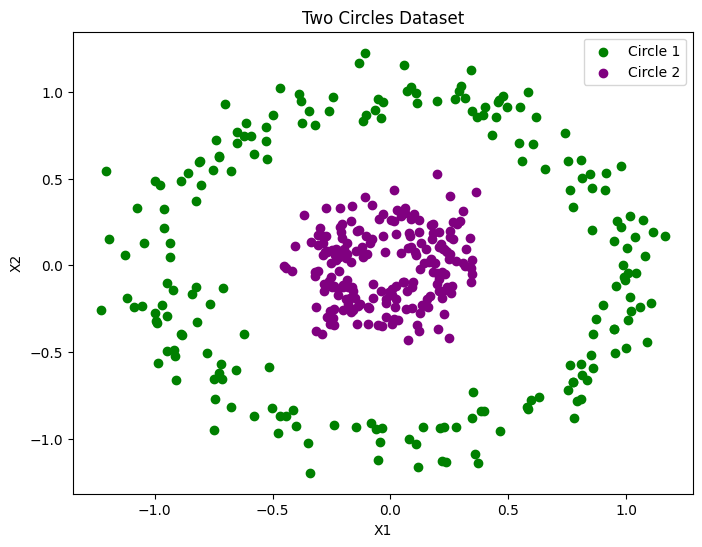

In [9]:
def generate_circle_data(radius, center, n_samples=200, noise_std=0.1):
    """
    Generate n_samples points along a circle with specified radius and center.
    Gaussian noise is added to the points.
    """
    angles = np.random.rand(n_samples) * 2 * np.pi
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    noise = np.random.normal(scale=noise_std, size=(n_samples, 2))
    return np.column_stack([x, y]) + noise

# Generate two circles dataset
X_circle_large = generate_circle_data(radius=1, center=(0, 0),noise_std=0.1)
X_circle_small = generate_circle_data(radius=0.25, center=(0, 0),noise_std=0.1)
X_circles = np.vstack([X_circle_large, X_circle_small])
y_circles = np.array([0]*200 + [1]*200)  # Labels: 0 for large circle, 1 for small circle

# Plotting the two circles dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_circles[y_circles == 0][:, 0], X_circles[y_circles == 0][:, 1], color='green', label='Circle 1')
plt.scatter(X_circles[y_circles == 1][:, 0], X_circles[y_circles == 1][:, 1], color='purple', label='Circle 2')
plt.title("Two Circles Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

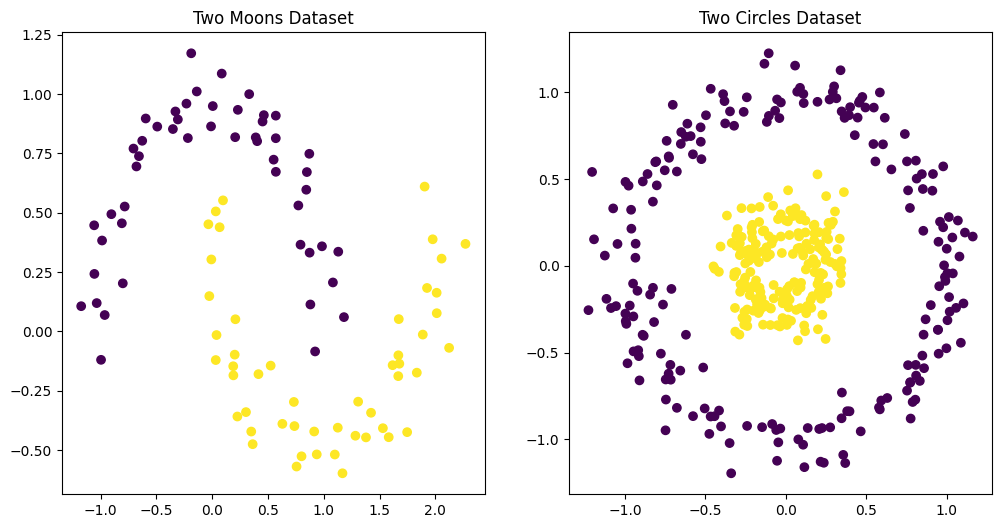

In [10]:
from sklearn.decomposition import KernelPCA

# Plotting the datasets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Two Moons Dataset")
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.subplot(1, 2, 2)
plt.title("Two Circles Dataset")
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles)
plt.show()

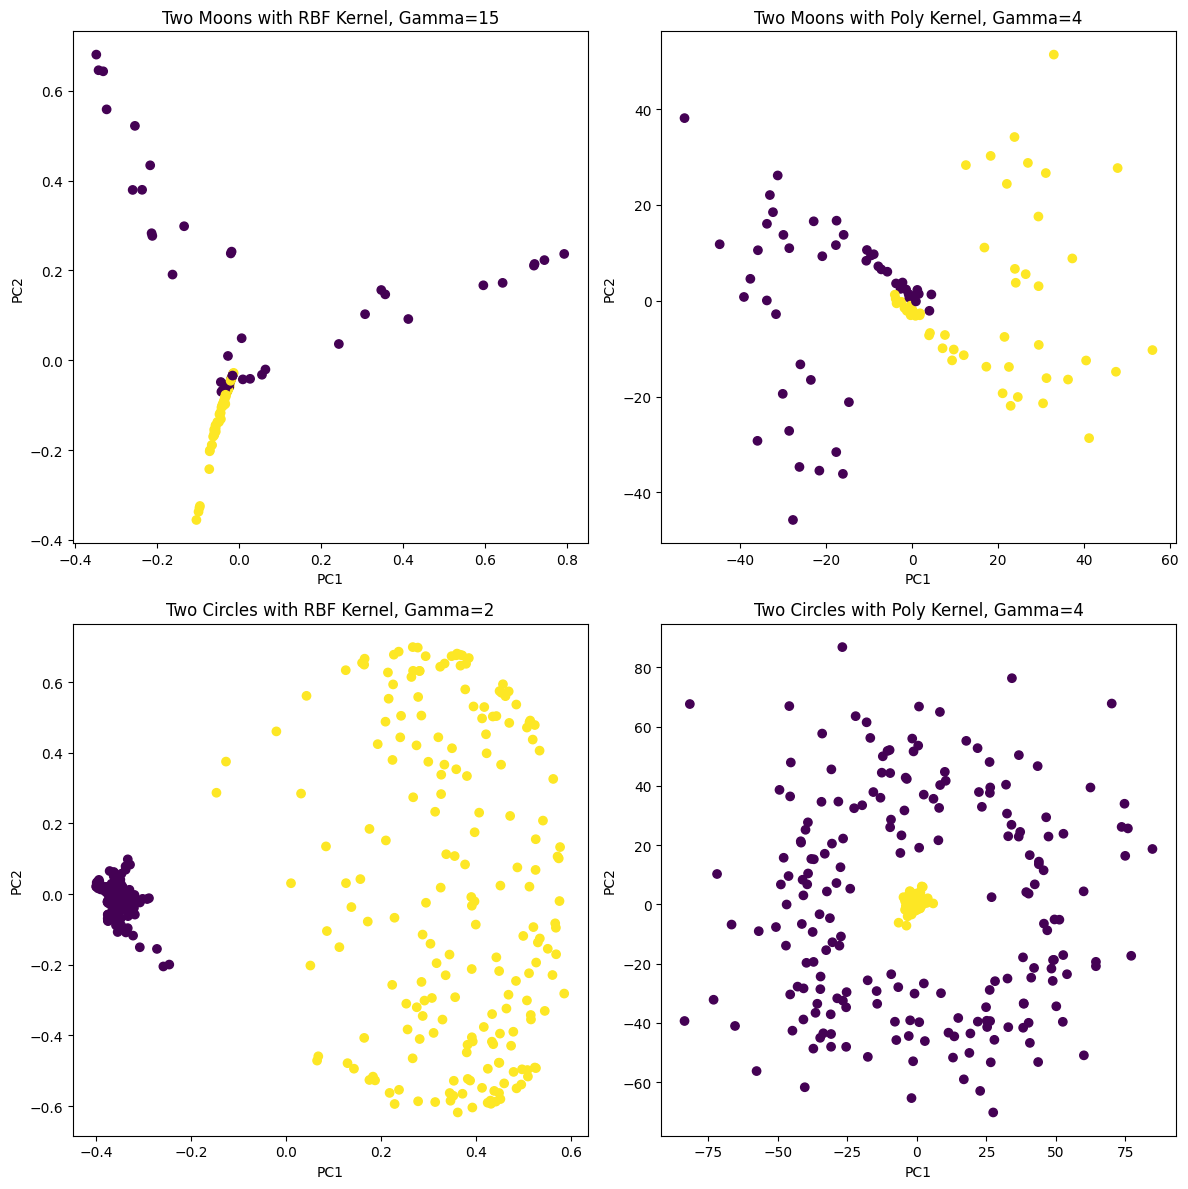

In [11]:
from sklearn.preprocessing import StandardScaler

# Function to apply Kernel PCA and plot the results
def apply_and_plot_kernel_pca(X, y, kernel, gamma, title):
    kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components=2)
    X_kpca = kpca.fit_transform(X)
    plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

# Standardizing the datasets before applying Kernel PCA
scaler_moons = StandardScaler()
X_moons_std = scaler_moons.fit_transform(X_moons)

scaler_circles = StandardScaler()
X_circles_std = scaler_circles.fit_transform(X_circles)

# Applying Kernel PCA with different parameters
plt.figure(figsize=(12, 12))

# Two Moons with RBF kernel (should separate well)
plt.subplot(2, 2, 1)
apply_and_plot_kernel_pca(X_moons_std, y_moons, kernel='rbf', gamma=15, title="Two Moons with RBF Kernel, Gamma=15")

# Two Moons with Poly kernel (might not separate well)
plt.subplot(2, 2, 2)
apply_and_plot_kernel_pca(X_moons_std, y_moons, kernel='poly', gamma=4, title="Two Moons with Poly Kernel, Gamma=4")

# Two Circles with RBF kernel (should separate well)
plt.subplot(2, 2, 3)
apply_and_plot_kernel_pca(X_circles_std, y_circles, kernel='rbf', gamma=2, title="Two Circles with RBF Kernel, Gamma=2")

# Two Circles with Poly kernel (might not separate well)
plt.subplot(2, 2, 4)
apply_and_plot_kernel_pca(X_circles_std, y_circles, kernel='poly', gamma=4, title="Two Circles with Poly Kernel, Gamma=4")

plt.tight_layout()
plt.show()


Text(0.5, 0, 'Class')

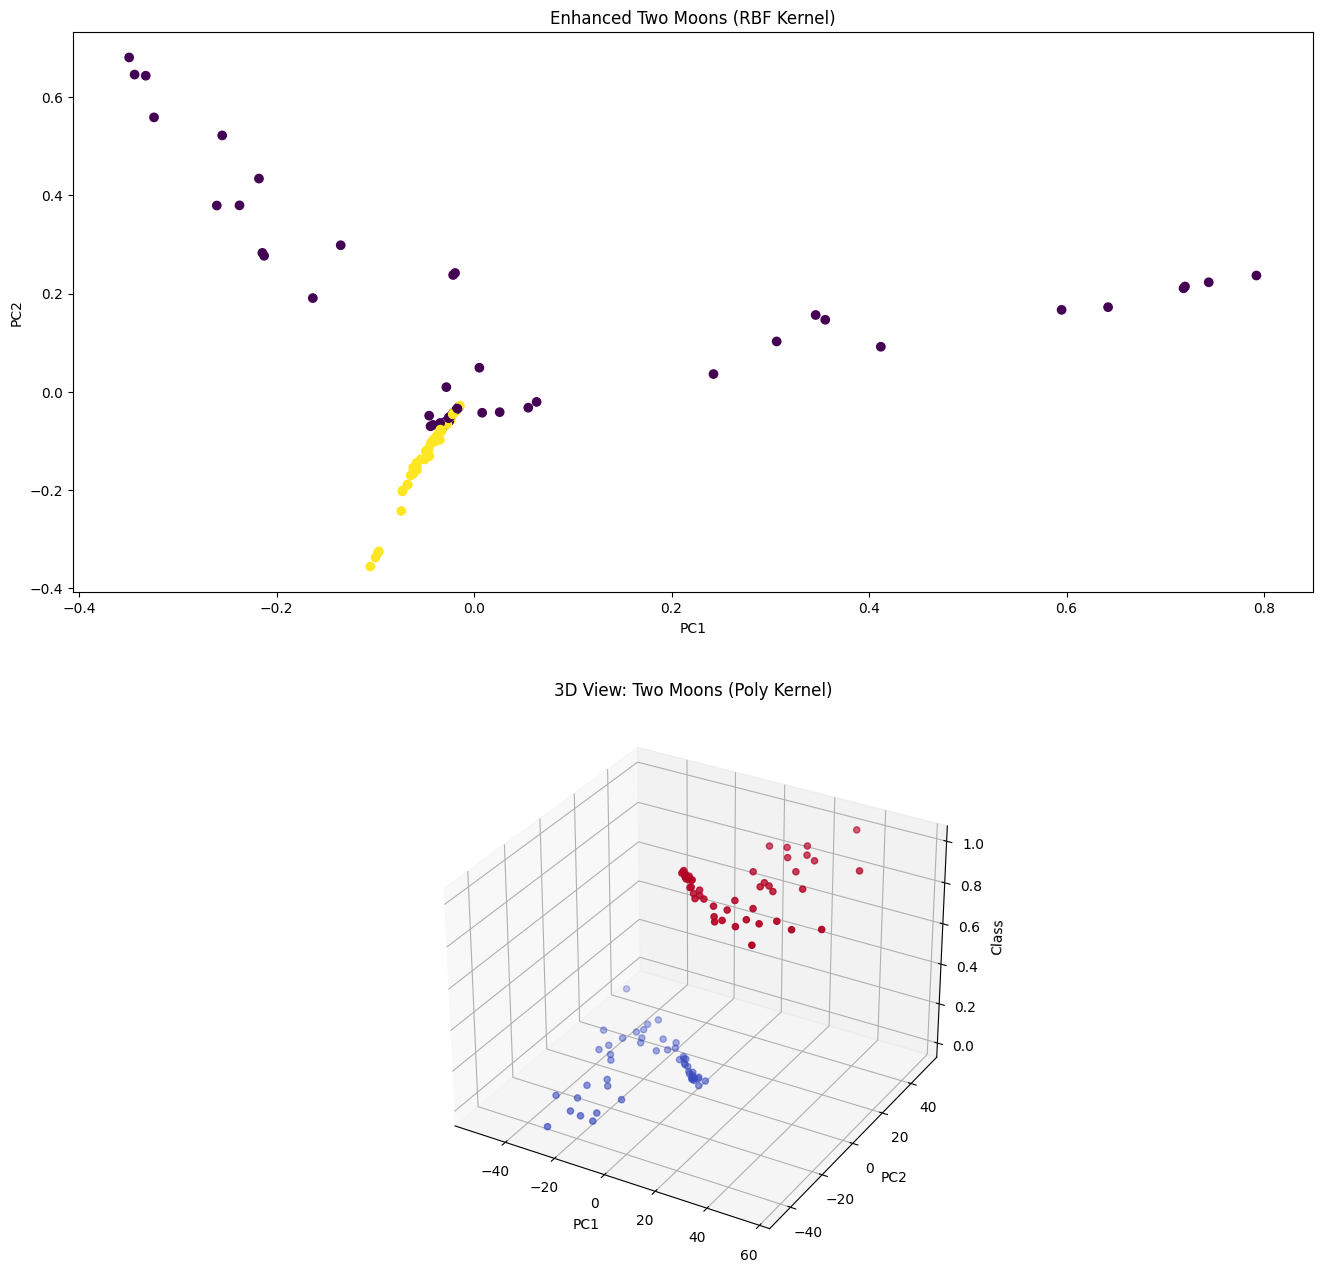

In [36]:
from mpl_toolkits.mplot3d import Axes3D

# Enhancing the visualizations with more creative elements
plt.figure(figsize=(16, 16))

# Two Moons with RBF kernel - Enhanced with different colors and annotations
plt.subplot(2, 2, 1)
apply_and_plot_kernel_pca(X_moons_std, y_moons, kernel='rbf', gamma=15, title="Enhanced Two Moons (RBF Kernel)")

# Two Moons with Poly kernel - Adding a 3D perspective
ax = plt.subplot(2, 2, 2, projection='3d')
kpca = KernelPCA(kernel='poly', gamma=4, n_components=2)
X_moons_kpca = kpca.fit_transform(X_moons_std)
ax.scatter(X_moons_kpca[:, 0], X_moons_kpca[:, 1], y_moons, c=y_moons, cmap="coolwarm")
ax.set_title("3D View: Two Moons (Poly Kernel)")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Class')

# Two Circles with RBF kernel - Enhanced visualization
plt.subplot(2, 2, 3)
apply_and_plot_kernel_pca(X_circles_std, y_circles, kernel='rbf', gamma=2, title="Enhanced Two Circles (RBF Kernel)")
plt.scatter(0, 0, c='red', marker='x')  # Marking the center

# Two Circles with Poly kernel - Enhanced with color map
plt.subplot(2, 2, 4)
apply_and_plot_kernel_pca(X_circles_std, y_circles, kernel='poly', gamma=4, title="Color Map: Two Circles (Poly Kernel)")

plt.tight_layout()
plt.show();
